In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import multiprocessing as mp
import random
from time import perf_counter

#from utils import Labels

In [2]:
# Define path names here
image_path_prefix = 'data/Category and Attribute Prediction Benchmark/Img/Img/'
image_to_category = 'data/Category and Attribute Prediction Benchmark/Anno/list_category_img.txt'
img_net_class_path = 'data/ImageNetClasses/imagenet1000_clsid_to_human.txt'
deep_fash_class_path = 'data/Category and Attribute Prediction Benchmark/Anno/list_category_cloth.txt'

n_images_loaded = -1 # -1 loads all

In [ ]:
## Transfer learning utilities
# These routines allow a layer from farther back in a model to be replaced 
# with an input layer so precalculated bottleneck features can be fed in
from keras.models import clone_model
from keras.models import Model
from keras.layers import Dense, InputLayer

def sub_in_layer(model,sub_out_name,sub_in_layer):
    """
    Replaces a node with an input layer and updates the model graph to reflect that
    change. Currently does not remove references to replaced nodes - prevents rerunning.
    Unable to handle layers with mulitple inbound_nodes. 
    """
    head_dict = { sub_out_name : sub_in_layer.output } # Assumes one output
    sub_out_layer = model.get_layer(sub_out_name)
    out_node_list = [ node for node in sub_out_layer.outbound_nodes ]
    sub_out_layer.outbound_nodes = []
    continue_loop = True
    while out_node_list and continue_loop:
        continue_loop = False
        for node in out_node_list[::-1]:
            modified = update_graph(model,head_dict,node,out_node_list)
            continue_loop = continue_loop | modified
        if not continue_loop:
            print('Could not find reference to inbound layer. This likely means'
                 ' output from a layer before the subbed-in layer is required. ')
    
def update_graph(model,head_dict,out_node,out_node_list):
    """Update graph layers to take output from tensors specified in head_dict"""
    if input_ref_present(out_node,head_dict):
        new_out_nodes = relink_graph(model,out_node,head_dict)
        out_node_list.remove(out_node)
        new_out_nodes = [node for node in new_out_nodes if node not in out_node_list]
        out_node_list += new_out_nodes
        return True
    return False

def input_ref_present(out_node,head_dict):
    return all( layer_name in head_dict.keys() 
               for layer_name in out_node.get_config()['inbound_layers'] )
                    
def relink_graph(model,out_node,head_dict):
    """
    Feed output of inbound_layers specified in out_node to the receiving layer. 
    Associate the receiving layer's name with its new output in head_dict. 
    Return the receiving layer's outbound nodes to continue relinking graph. 
    """
    new_link_name = out_node.get_config()['outbound_layer']
    new_link_layer = model.get_layer(new_link_name)
    if len(new_link_layer.inbound_nodes) > 1:
        raise NotImplementedError('Layer {} used in multiple places'.format(new_link_name)
                                  + ' (has multiple inbound_nodes). Unable to relink graph.')
    new_link_layer.inbound_nodes = []
    if len(out_node.get_config()['inbound_layers']) == 1:
        x = new_link_layer(head_dict[out_node.get_config()['inbound_layers'][0]])
    else:
        inbound_list = [ head_dict[l] for l in out_node.get_config()['inbound_layers'] ]
        x = new_link_layer(inbound_list)
    head_dict[new_link_name] = x
    new_out_nodes = [ node for node in new_link_layer.outbound_nodes ]
    new_link_layer.outbound_nodes = []
    return new_out_nodes

def model_top_at_layer(model,layer_name):
    """
    Returns the part of model from layer layer_name until the output layer
    with layer layer_name replaced by an InputLayer
    """
    mod_cop = clone_model(model)
    mod_cop.set_weights(model.get_weights())
    
    inp = InputLayer(model.get_layer(layer_name).output_shape[1:])
    sub_in_layer(mod_cop,layer_name,inp)
    x = mod_cop.layers[-1].get_output_at(1)
    
    return Model(inp.input,x)

def replace_out_layer(model,num_outputs):
    """Replaces the last layer of a model with a dense layer with num_outputs outputs"""
    model.layers.pop()
    model.layers[-1].outbound_nodes = []
    
    new_layer = Dense(num_outputs)
    new_out = new_layer(model.layers[-1].get_output_at(1))
    new_model = Model(model.input,new_out)
    return new_model

def load_model_top(model,name):
    max_layer_dict = {
    'resnet' : 'activation_46',
    'inception_v3' : 'mixed9',
    'xception' : 'add_28',
    }
    model_top = model_top_at_layer(model,max_layer_dict[name])
    replace_out_layer(model_top,10)
    model_top.load()

In [3]:
## Load the classifiers
from keras.applications.resnet50 import ResNet50
#from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception

res50 = ResNet50(weights='imagenet')
incv3 = InceptionV3(weights='imagenet')
xcept = Xception(weights='imagenet')

model_dict = {
        'resnet' : res50,
        'inception_v3' : incv3,
        'xception' : xcept,
    }

#for name, model in model_dict.items():
    

Using TensorFlow backend.


In [78]:
from skimage.segmentation import slic # produces integer mask
from skimage.future.graph import rag_mean_color, cut_normalized
from keras.applications.resnet50 import ResNet50

    # Each super pixel will be a dictionary containing:
    #   - Location info (bool mask for simplicity)
    #   - Average color RGB
    #   - Indices of neighboring super pixels
    # The full list of super pixels will be contained in a list.
    # The indices of this list are the indices referenced above

    # This thing is a major memory hog. Each image gets copied
    # multiple (3?) times and a copy of the model instances must 
    # be loaded for each process
    # That'll be really slow too. Need a way to share model between processes
    # This: https://stackoverflow.com/questions/25477470
    # seems to say I can use a manager class, but need to be careful what's in
    # my global namespace and not touch too much as copy-on-write can still 
    # raise mem requirements
    
class ImageSegmenterFactory():
    """
    Stores configuration information for ImageSegmenters and allows
    processing a list of images in parallel using them
    """
#    __slots__ = ('null_pattern','n_super_pixels','compactness','max_iters')

    def __init__(self,null_pattern,n_super_pixels,compactness,
                 low_threshold=1e-8,high_threshold=100,max_iters=10):
        """
        null_pattern - Image that replaces the portions of the segmented image deemed irrelevant
        n_super_pixels - Roughly translates to the number of super pixels normalized cuts acts on
        compactness - The larger this is the more spatially localized super pixels are
        low_threshold - The threshold argument for sklearns's cut_normalized will not dip below this
        high_threshold - The threshold argument for sklearns's cut_normalized will not go above this
        max_iters - The number of times to refine the run cut_normalized's
        """
        self.config = {
            'null_pattern' : null_pattern,
            'n_super_pixels' : n_super_pixels,
            'compactness' : compactness,
            'low_threshold' : low_threshold,
            'high_threshold' : high_threshold,
            'max_iters' : max_iters
        }

    @staticmethod
    def get_pixel_mask(proxy_model,image_preproc,config,q,image):
        q.put('About to go in')
        segmenter = ImageSegmenter(proxy_model[0],image_preproc,config,q,image)
        q.put('Made object')
        segmenter.segment_image()
        return segmenter.pixel_mask
    
    @staticmethod
    def load_model(model_path):
        if model_path == 'resnet':
            return res50
        raise NotImplementedError
    
    @staticmethod
    def log_printer(path,q):
        with open(path,'w') as out:
            out.write('Getting Started\n')
            out.flush()
            while True:
                o = q.get()
                if o == 'Done':
                    break
                out.write(o+'\n')
                out.flush()
    
    def segment_images(self,model_path,image_preproc,images,log_path):
        num_cpus = mp.cpu_count()
        proc_pool = mp.Pool(num_cpus - 1)
        
        # Set up a log file to monitor progress
        man = mp.Manager()
        q = man.Queue()
        proc_pool.apply_async(self.log_printer,(log_path,q))
        
        # Allow dispatched ImageSegmenter objects to access a single model instance
        model = self.load_model(model_path)
        #proxy_model = man.list([model])
        
        segment_masks = []
        for img in images:
            segment_masks.append(self.get_pixel_mask([model],image_preproc,self.config,q,img))
        #segment_masks = proc_pool.map(partial(self.get_pixel_mask,proxy_model,image_preproc,self.config,q),images)
        return segment_masks

In [79]:
class ImageSegmenter():
    """
    This class attempts to segment an image into object and non-object regions
    using a pretrained classifier to gauge the quality of its segmentation
    """
#    __slots__ = ('image','masked_image','null_pattern',
#                 'max_iters','pixel_mask','rag')
        
    def __init__(self,model,image_preproc,config,q,image):
        """Store the image info needed """
        q.put('So it inits')
        self.model = model
        self.image_preproc = image_preproc
        self.q = q
        q.put('init assign done 1')
        
        self.actual_class = self.predict_class(self.model,self.image_preproc,image.astype(np.float16),self.q)
        
        self.image = image # Will be iteratively masked
        self.pixel_mask = np.ones(image.shape[:2],dtype=bool) # False means use null pattern
        self.super_pixels = slic(image,config['n_super_pixels'],config['compactness'])
        self.rag = rag_mean_color(image, self.super_pixels, mode='similarity')
        q.put('init assign done 2')
        
        self.null_pattern = config['null_pattern']
        self.max_iters = config['max_iters']
        self.low_threshold = np.log10(config['low_threshold'])
        self.high_threshold = np.log10(config['high_threshold'])
        q.put('init assign done 3')
    
    def segment_image(self):
        """
        Calculate a pixel_mask specifying the location of the object in this 
        class' image. 
        """
        if self.actual_class == -1:
            self.pixel_mask = np.zeros(self.image.shape,dtype=bool)
            return
        self.q.put('So it begins')
        self._raise_low_threshold()
        self.q.put('So it has risen')
        self._lower_high_threshold()
        self.q.put('So it has lowered')
        self._clean_segmentation()
    
    @staticmethod
    def mask_image(image,null_pattern,pixel_mask):
        """
        Replaces masked portions of image with values of null_pattern.
        Last dimension must be channel. True values in mask mean show image. 
        """
        masked_image = (~pixel_mask.T*null_pattern.T).T + \
                         (pixel_mask.T*image.T).T
        return masked_image
    
    @staticmethod
    def predict_class(model,image_preproc,image,q):
        """
        Returns the predicted class for this image.
        
        Predicted class satisfies the criteria:
        - Has the highest predicted probability
        - Has a probability 1.5 times higher than expected from randomly guessing
        
        The 1.5 times value is arbitrary
        """
#        return (random.random()*2 + 1)//2
        
        image = image_preproc(image)
        q.put('Predicting'+str(model))
        pred = model.predict(np.stack([image]))
        pred = np.ravel(pred)
        pred_class = np.argmax(pred)
        q.put('Predicted '+str(pred_class)+' at '+str(pred[pred_class]))
        if pred[pred_class] > 1.5*(1/len(pred)):
            return pred_class
        return -1
        
    @staticmethod
    def _adjust_threshold(threshold,cur_thresh,too_high,inc_rate,overshot):
        """
        Adjust the lower threshold in a way that ensures we never attempt the same threshold twice
        and iteratively approach the threshold yielding the smallest segmentation the
        classifier still recognizes as the correct object
        """
        if too_high: # Don't jump above the lower bound so much
            inc_rate = inc_rate/2
            overshot = True
        elif overshot: # Raise the lower bound but decrease the inc_rate
            threshold = cur_thresh
            inc_rate = inc_rate/2 # If we didn't lower inc_rate we'd be repeating a value
        else: # Raise the lower bound
            threshold = cur_thresh
        return threshold, inc_rate, overshot
        
    def _raise_low_threshold(self):
        """
        This function attempts to raise the low_threshold limit to 
        limit the areas in the picture considered part of the object
        """
        inc_rate = 1; overshot = False
        for i in range(self.max_iters):
            self.q.put('Raise number '+str(i))
            cur_thresh = self.low_threshold + inc_rate
            norm_cuts = cut_normalized(self.super_pixels,self.rag,thresh=10**cur_thresh,in_place=False)
            self.q.put('Finished norm_cuts at '+str(cur_thresh))
            too_high = self._narrow_regions(norm_cuts)
            self.q.put('Narrowed regions: '+str(too_high))
            self.low_threshold, inc_rate, overshot = self._adjust_threshold(self.low_threshold,cur_thresh,
                                                                            too_high,inc_rate,overshot)
            self.q.put('Summary: '+', '.join([str(self.low_threshold),str(inc_rate),str(overshot)]))
        # Lock in the most refined pixel_mask found
        self.image = self.mask_image(self.image,self.null_pattern,self.pixel_mask)

    def _narrow_regions(self,norm_cuts):
        """
        Test each normalized cuts region to see if the classifier recognizes it as
        the correct class. 
        """
        norm_cuts = self.pixel_mask * (norm_cuts + 1) # Ignore regions deemed irrelevant
        relevant_regions = []
        self.q.put('Starting to narrow '+str(len(np.unique(norm_cuts))))
        for r in np.unique(norm_cuts):
            # Skip the nulled region
            if r == 0:
                continue
            masked_image = self.mask_image(self.image,self.null_pattern,norm_cuts == r)
            self.q.put('Masked region '+str(r))
            pred_class = self.predict_class(self.model,self.image_preproc,masked_image.astype(np.float16),self.q)
            self.q.put('Predicted on '+str(r))
            if pred_class == self.actual_class:
                relevant_regions.append(r)
        self.q.put('Num of relevant: '+str(len(relevant_regions)))
        if len(relevant_regions) == 1:
            # Don't use intersection in case correct region area fluctuates
            # and region grows too small
            self.pixel_mask = (norm_cuts == relevant_regions[0])
            return False
        return True
    
    def _lower_high_threshold(self):
        """
        This function attempts to lower the high_threshold limit to
        shave off the small regions that don't belong to the object
        but get lumped together with it.
        
        Note that the image super pixels and rag are not recalculated -
        we do not want the null pattern to blend with the image. 
        """
        dec_rate = 1; overshot = False
        # If no iters or unable to refine high_threshold, relevant regions are True pixel_mask entries
        best_relevant_regions = [1]; best_reg_def = self.pixel_mask
        for i in range(self.max_iters):
            self.q.put('Lower number '+str(i))
            cur_thresh = self.high_threshold - dec_rate
            norm_cuts = cut_normalized(self.super_pixels,self.rag,thresh=10**cur_thresh,in_place=False)
            self.q.put('Cut norm at '+str(cur_thresh))
            too_low, relevant_regions = self._refine_regions(norm_cuts)
            if not too_low:
                best_relevant_regions = relevant_regions
                best_reg_def = norm_cuts
            self.high_threshold, dec_rate, overshot = self._adjust_threshold(self.high_threshold,cur_thresh,
                                                                             too_low,dec_rate,overshot)
            self.q.put('Summary: '+', '.join([str(self.high_threshold),str(dec_rate),str(overshot)]))
        best_relevant_regions = relevant_regions
        best_reg_def = norm_cuts
        # Lock in the most refined pixel_mask found
        self.pixel_mask = np.zeros(self.pixel_mask.shape,dtype=bool)
        # The previously excluded regions will not be in the best_relevant_regions list
        for r in best_relevant_regions:
            self.pixel_mask = self.pixel_mask | (best_reg_def == r)
    
    def _refine_regions(self,norm_cuts):
        """
        If removing a region, causes a misclassification that region
        is deemed part of the object and we have segments that are too
        big. 
        
        I expect this will cause the object to be seen as only small
        chunks. A more accurate (and more computationally efficient) approach
        might be to do the region narrowing and then slightly oversegment from 
        there. Will attempt this first. 
        """
        norm_cuts = self.pixel_mask * (norm_cuts + 1) # Ignore regions deemed irrelevant
        relevant_regions = []
        for r in np.unique(norm_cuts):
            # Skip the nulled region
            if r == 0:
                continue
            # Remove only the considered region (and the area already deemed irrelevant)
            masked_image = self.mask_image(self.image,self.null_pattern,norm_cuts != r)
            pred_class = self.predict_class(self.model,self.image_preproc,masked_image.astype(np.float16),self.q)
            if pred_class == self.actual_class:
                relevant_regions.append(r)
        self.q.put('Found rel regions '+str(len(relevant_regions))+' of '+str(len(np.unique(norm_cuts))))
        return len(relevant_regions) != 0, relevant_regions
    
    def _clean_segmentation(self):
        """
        Attempts to remove small gaps in the pixel mask to make the image segmentation look
        more natural.
        """
        pass

In [51]:
from skimage.color import label2rgb
from skimage.io import imread, imshow
from skimage.transform import rescale
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input as res_preproc

res50 = ResNet50(weights='imagenet')
image = imread('dog_test.jpeg')
image = rescale(image,224/image.shape[0])
image = image[:,90:314]
img = np.copy(image)
proc_image = res_preproc(image.astype(np.float64))

In [82]:
(image == img).all()

True

In [55]:
class DummyQueue():
    def put(self,x):
        print(x)
q = DummyQueue()
ImageSegmenter.predict_class(res50,res_preproc,image.astype(np.float32),q)

Predicting
Predicted 916 at 0.243103


916

In [84]:
class Predicter():
    def load_model(self,model_path):
        if model_path == 'resnet':
            self.model = ResNet50(weights='imagenet')
            print(dir(self))
            return
        raise NotImplementedError
        
    def predict(self,image):
        return self.model.predict(image)

pred = Predicter()
man = mp.Manager()
#pred.load_model('resnet')
prox_mod = man.list([pred])

In [47]:
from keras.models import Model
from keras.layers import Lambda, InputLayer

inp = InputLayer(image.shape)
y = Lambda(new_preproc)(inp.output)
mod = Model(inp.input,y)

In [ ]:
cut_normalized(self.super_pixels,self.rag,thresh=10**cur_thresh,in_place=False)

In [80]:
segmenter = ImageSegmenterFactory(np.zeros(image.shape,dtype=np.uint8),1000,100,
                 low_threshold=1e-8,high_threshold=100,max_iters=10)

In [81]:
pix_mask = segmenter.segment_images('resnet',res_preproc,[image],'tmp_log')

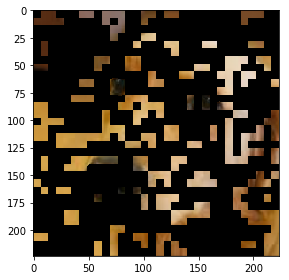

In [47]:
imshow((pix_mask[0].T*image.T).T)
plt.show()

In [88]:
from skimage.segmentation import slic # produces integer mask
from skimage.future.graph import rag_mean_color, cut_normalized
from skimage.color import label2rgb
from skimage.io import imread, imshow

image = imread('test_img.jpg')
pixel_mask = slic(image,1000,100)
rag = rag_mean_color(image, pixel_mask, mode='similarity')
cn = cut_normalized(pixel_mask,rag,thresh=5e-3,in_place=False)

# region_labeled = label2rgb(sup_pixels, image, kind='avg')
# imshow(region_labeled)
# plt.show()

In [91]:
cn.shape

(285, 250, 3)

In [87]:
edge_vals = np.zeros(len(rag.edges()))
for i, e in enumerate(rag.edges()):
    edge_vals[i] = rag.get_edge_data(*e)['weight']

In [100]:
thresh = 1e-20
len_list = []
for i in range(25):
    cn = cut_normalized(pixel_mask,rag,thresh=thresh,in_place=False)
    thresh *= 10
    len_list.append((thresh,len(np.unique(cn))))

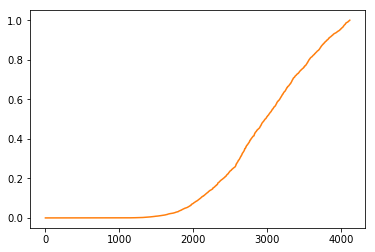

In [116]:
plt.plot(np.sort(edge_vals))
plt.show()

(25, 2)


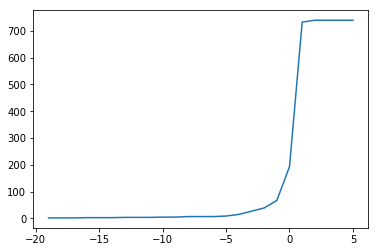

In [109]:
len_arr = np.array(len_list)
print(len_arr.shape)
plt.plot(np.log10(len_arr[:,0]),len_arr[:,1])
plt.show()

In [88]:
edge_vals.min()

4.052683705439187e-127

In [99]:
len(np.unique(cn))

1

In [149]:
cn.shape

(285, 250)

/Users/magee/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


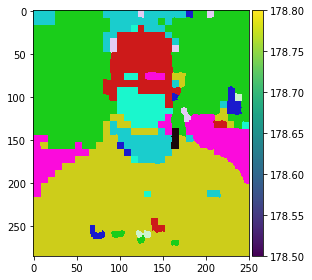

In [178]:
region_labeled = label2rgb(cn, np.zeros(image.shape) + 255, kind='overlay')
#region_labeled = label2rgb(cn, image, kind='avg')
imshow(region_labeled)
plt.show()

In [63]:
edge_count = 0
for l in rag.adjacency_list():
    edge_count += len(l)
edge_count

8228

In [20]:
np.copy(np.unique(np.array([[1,2],[3,1]])))

array([1, 2, 3])

In [ ]:
## Create a bool mask for each image and class following the algorithm described in the proposal


In [ ]:
## Compare the bounding boxes from the masks to reference bounding boxes
# Intersection over Union

# Center Correctness